In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
list=[]
for i in range(1,2):
  with open(f'/Users/chiararizzato/Downloads/peeringdb_2_dump_2024_01_{i:02d}.json') as file: 
    doc=json.load(file)
  dfPeering=pd.DataFrame.from_records(doc['net']['data'],index='id')
  list.append(dfPeering)

dfPeering=pd.concat(list)

dfPeering=dfPeering[['asn','name','info_type']]
dfPeering.head(10)

,asn,name,info_type
id,,,
1,4436,GTT Communications (AS4436),NSP
2,20940,Akamai Technologies,Content
3,31800,DALnet IRC Network,Non-Profit
5,3303,Swisscom,Cable/DSL/ISP
6,22773,Cox Communications,Cable/DSL/ISP
7,6079,RCN,Cable/DSL/ISP
8,23148,Verizon Managed Router Service,
9,7843,Charter Communications (7843),Cable/DSL/ISP
10,1299,Arelion (Twelve99),NSP


In [3]:
df = pd.read_csv("/Users/chiararizzato/Downloads/data.csv")
df=df.set_index('asn').join(dfPeering.set_index('asn'))
df.head(10)

,type,provider_free,tier1_free,hierachy_free,total,name,info_type
asn,,,,,,,
615,other,2,2,2,75982,NaN,NaN
23815,other,36815,36815,34340,75982,JPIX Route Servers,Route Server
17267,other,1,1,1,75982,NaN,NaN
396530,other,1,1,1,75982,NaN,NaN
328711,other,1,1,1,75982,Intaweb,Cable/DSL/ISP
21345,other,1,1,1,75982,Broadcom (EMEA),Content
30781,other,62912,58354,42927,75982,Free PRO,NSP
44440,other,1,1,1,75982,NaN,NaN
46624,other,1,1,1,75982,NaN,NaN


In [4]:
def plot_hierarchy_free(df):
    df=df.sort_values(by='hierachy_free',ascending=False)
    df=df.head(30)
    
    fig, ax = plt.subplots(figsize=(30,20))

    color_map= {'cloud_provider': 'blue','tier1':'red','tier2':'green','other':'gray'}
    df['color']=df['type'].map(color_map)

    ax.bar(df['name'].astype(str), df['hierachy_free'], align='center',color=df['color'])
    #ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_ylabel('Hierarchy Free')
    ax.set_xlabel('ASN')
    ax.set_title('Hierarchy Free per ASN')
    plt.xticks(rotation=90)
    legend_labels={'tier1':'tier1','cloud_provider':'cloud_provider','tier2':'tier2','other':'other'}
    legend_handles = [plt.Rectangle((0,0), 1, 1, color=color_map[type]) for type in df['type'].unique()]
    ax.legend(legend_handles, legend_labels.values(), title='Type', loc='upper right')


    plt.show()

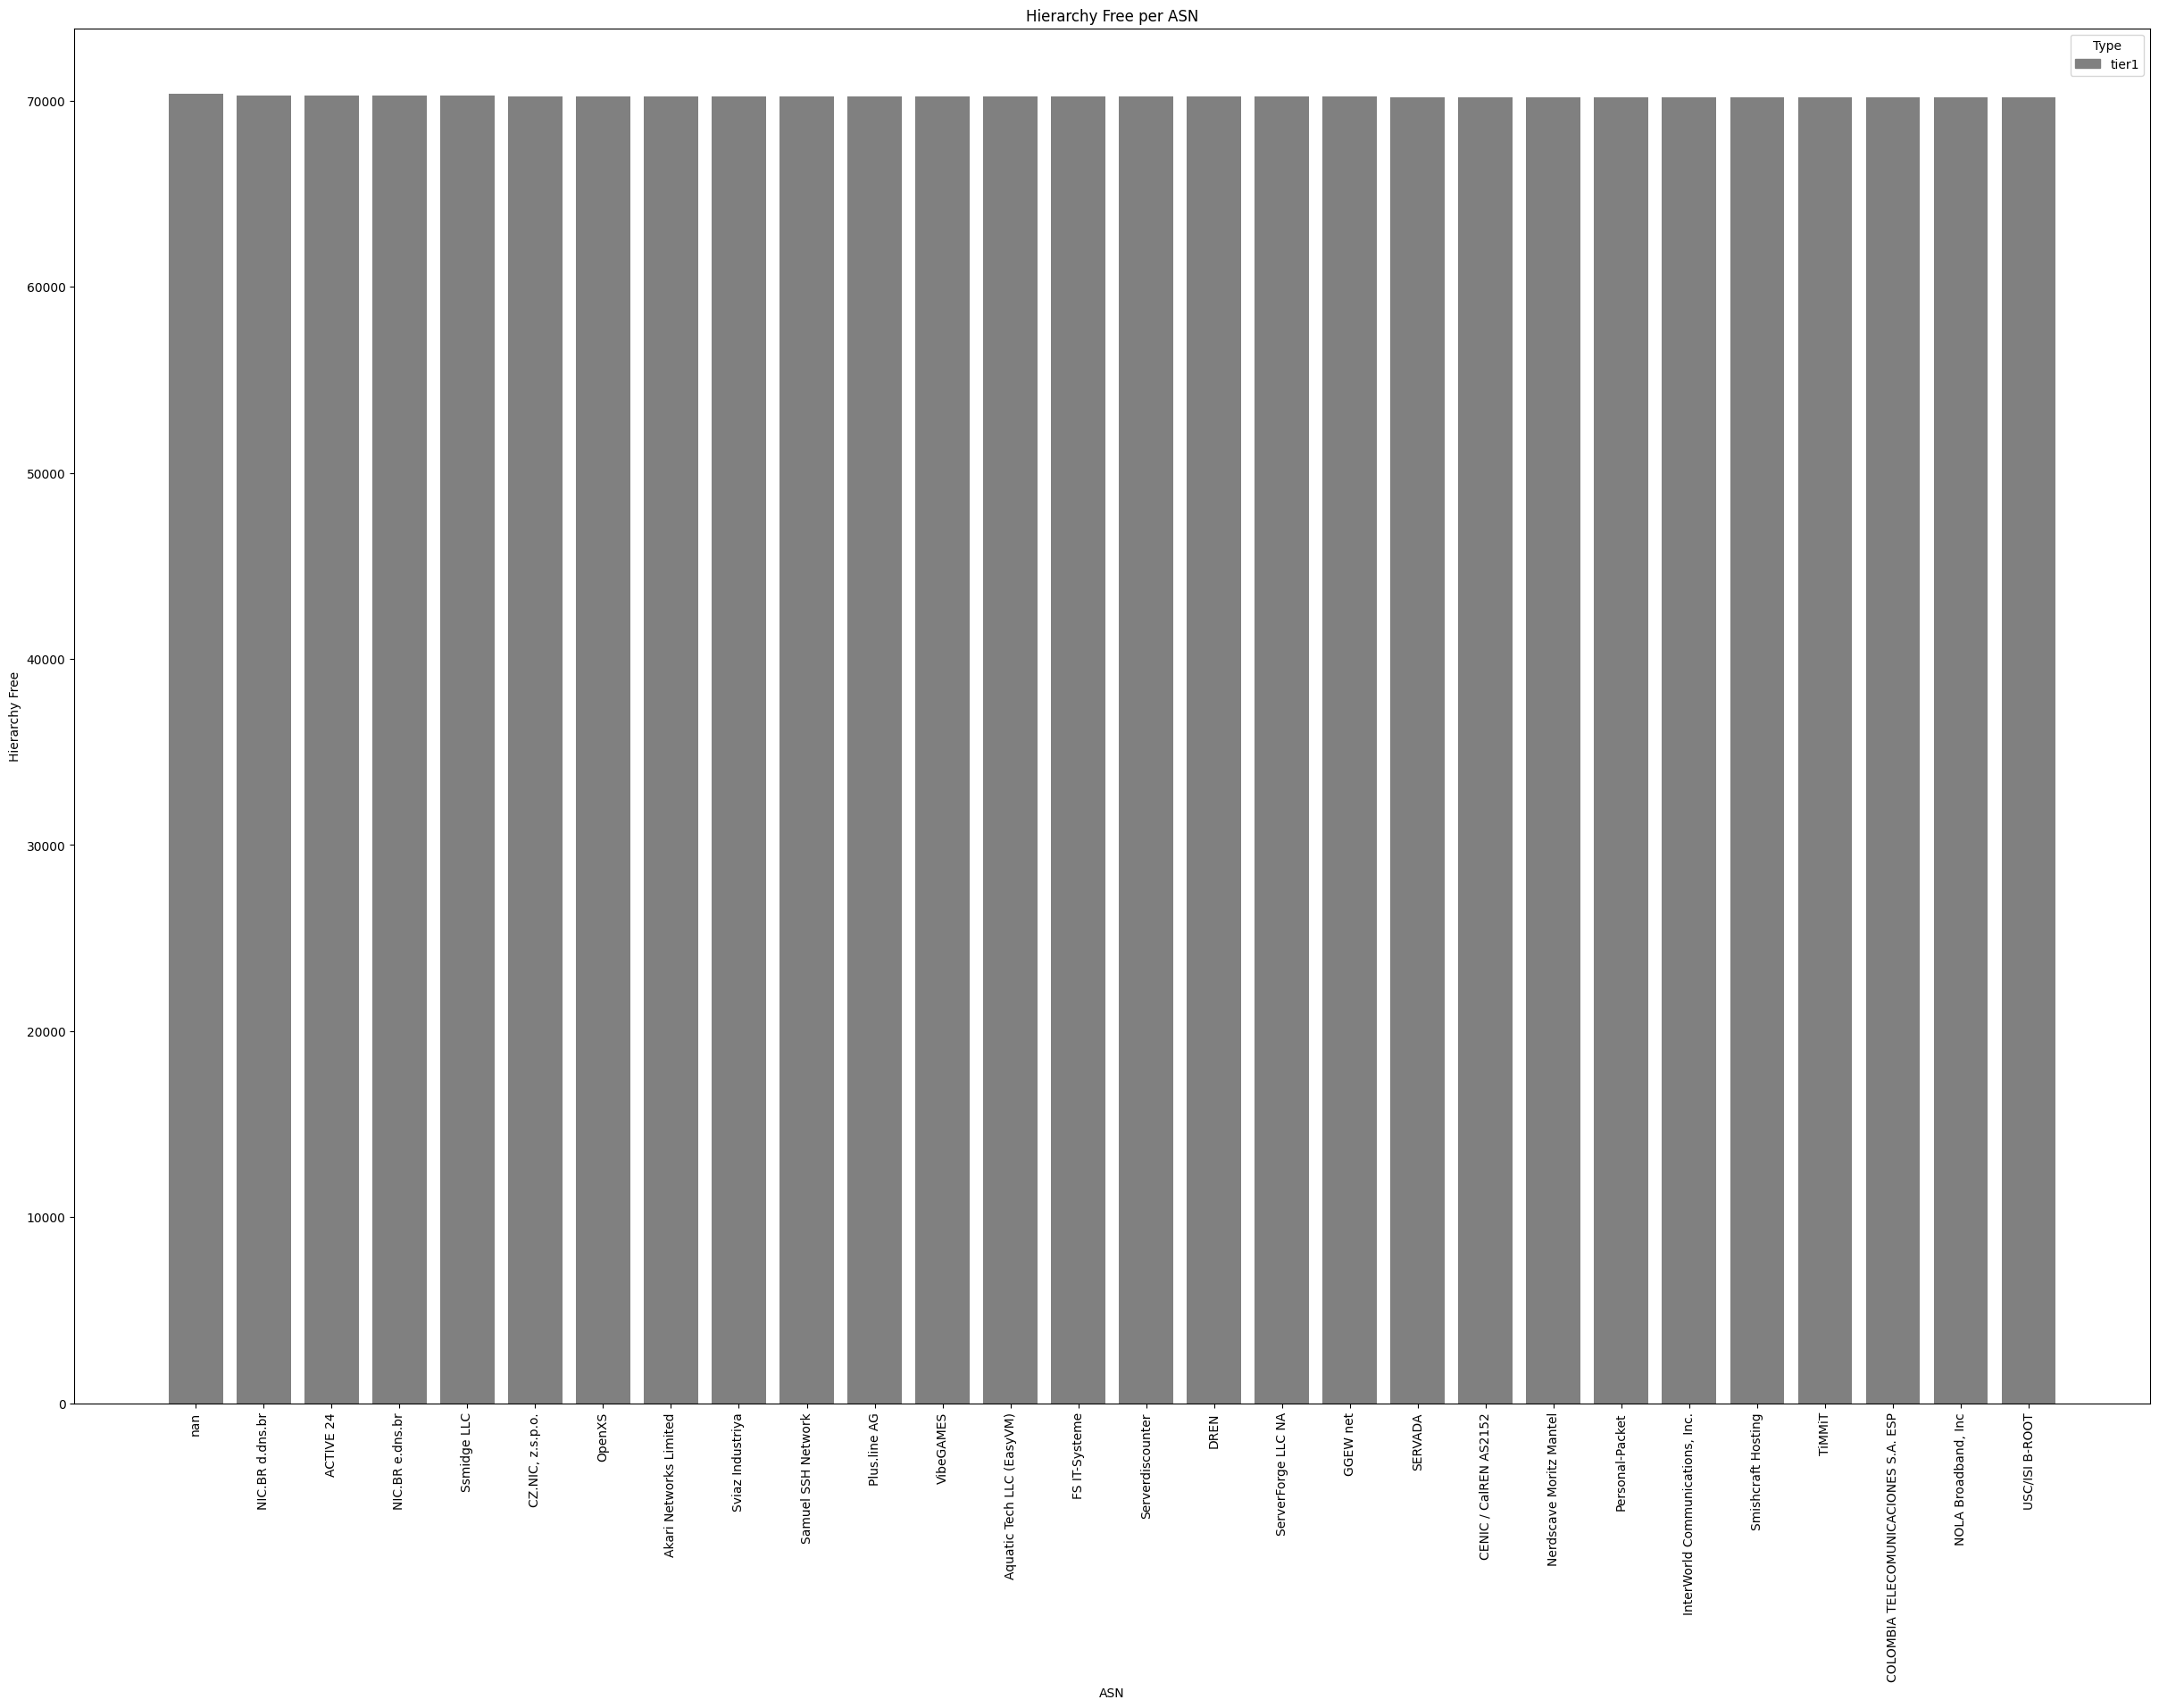

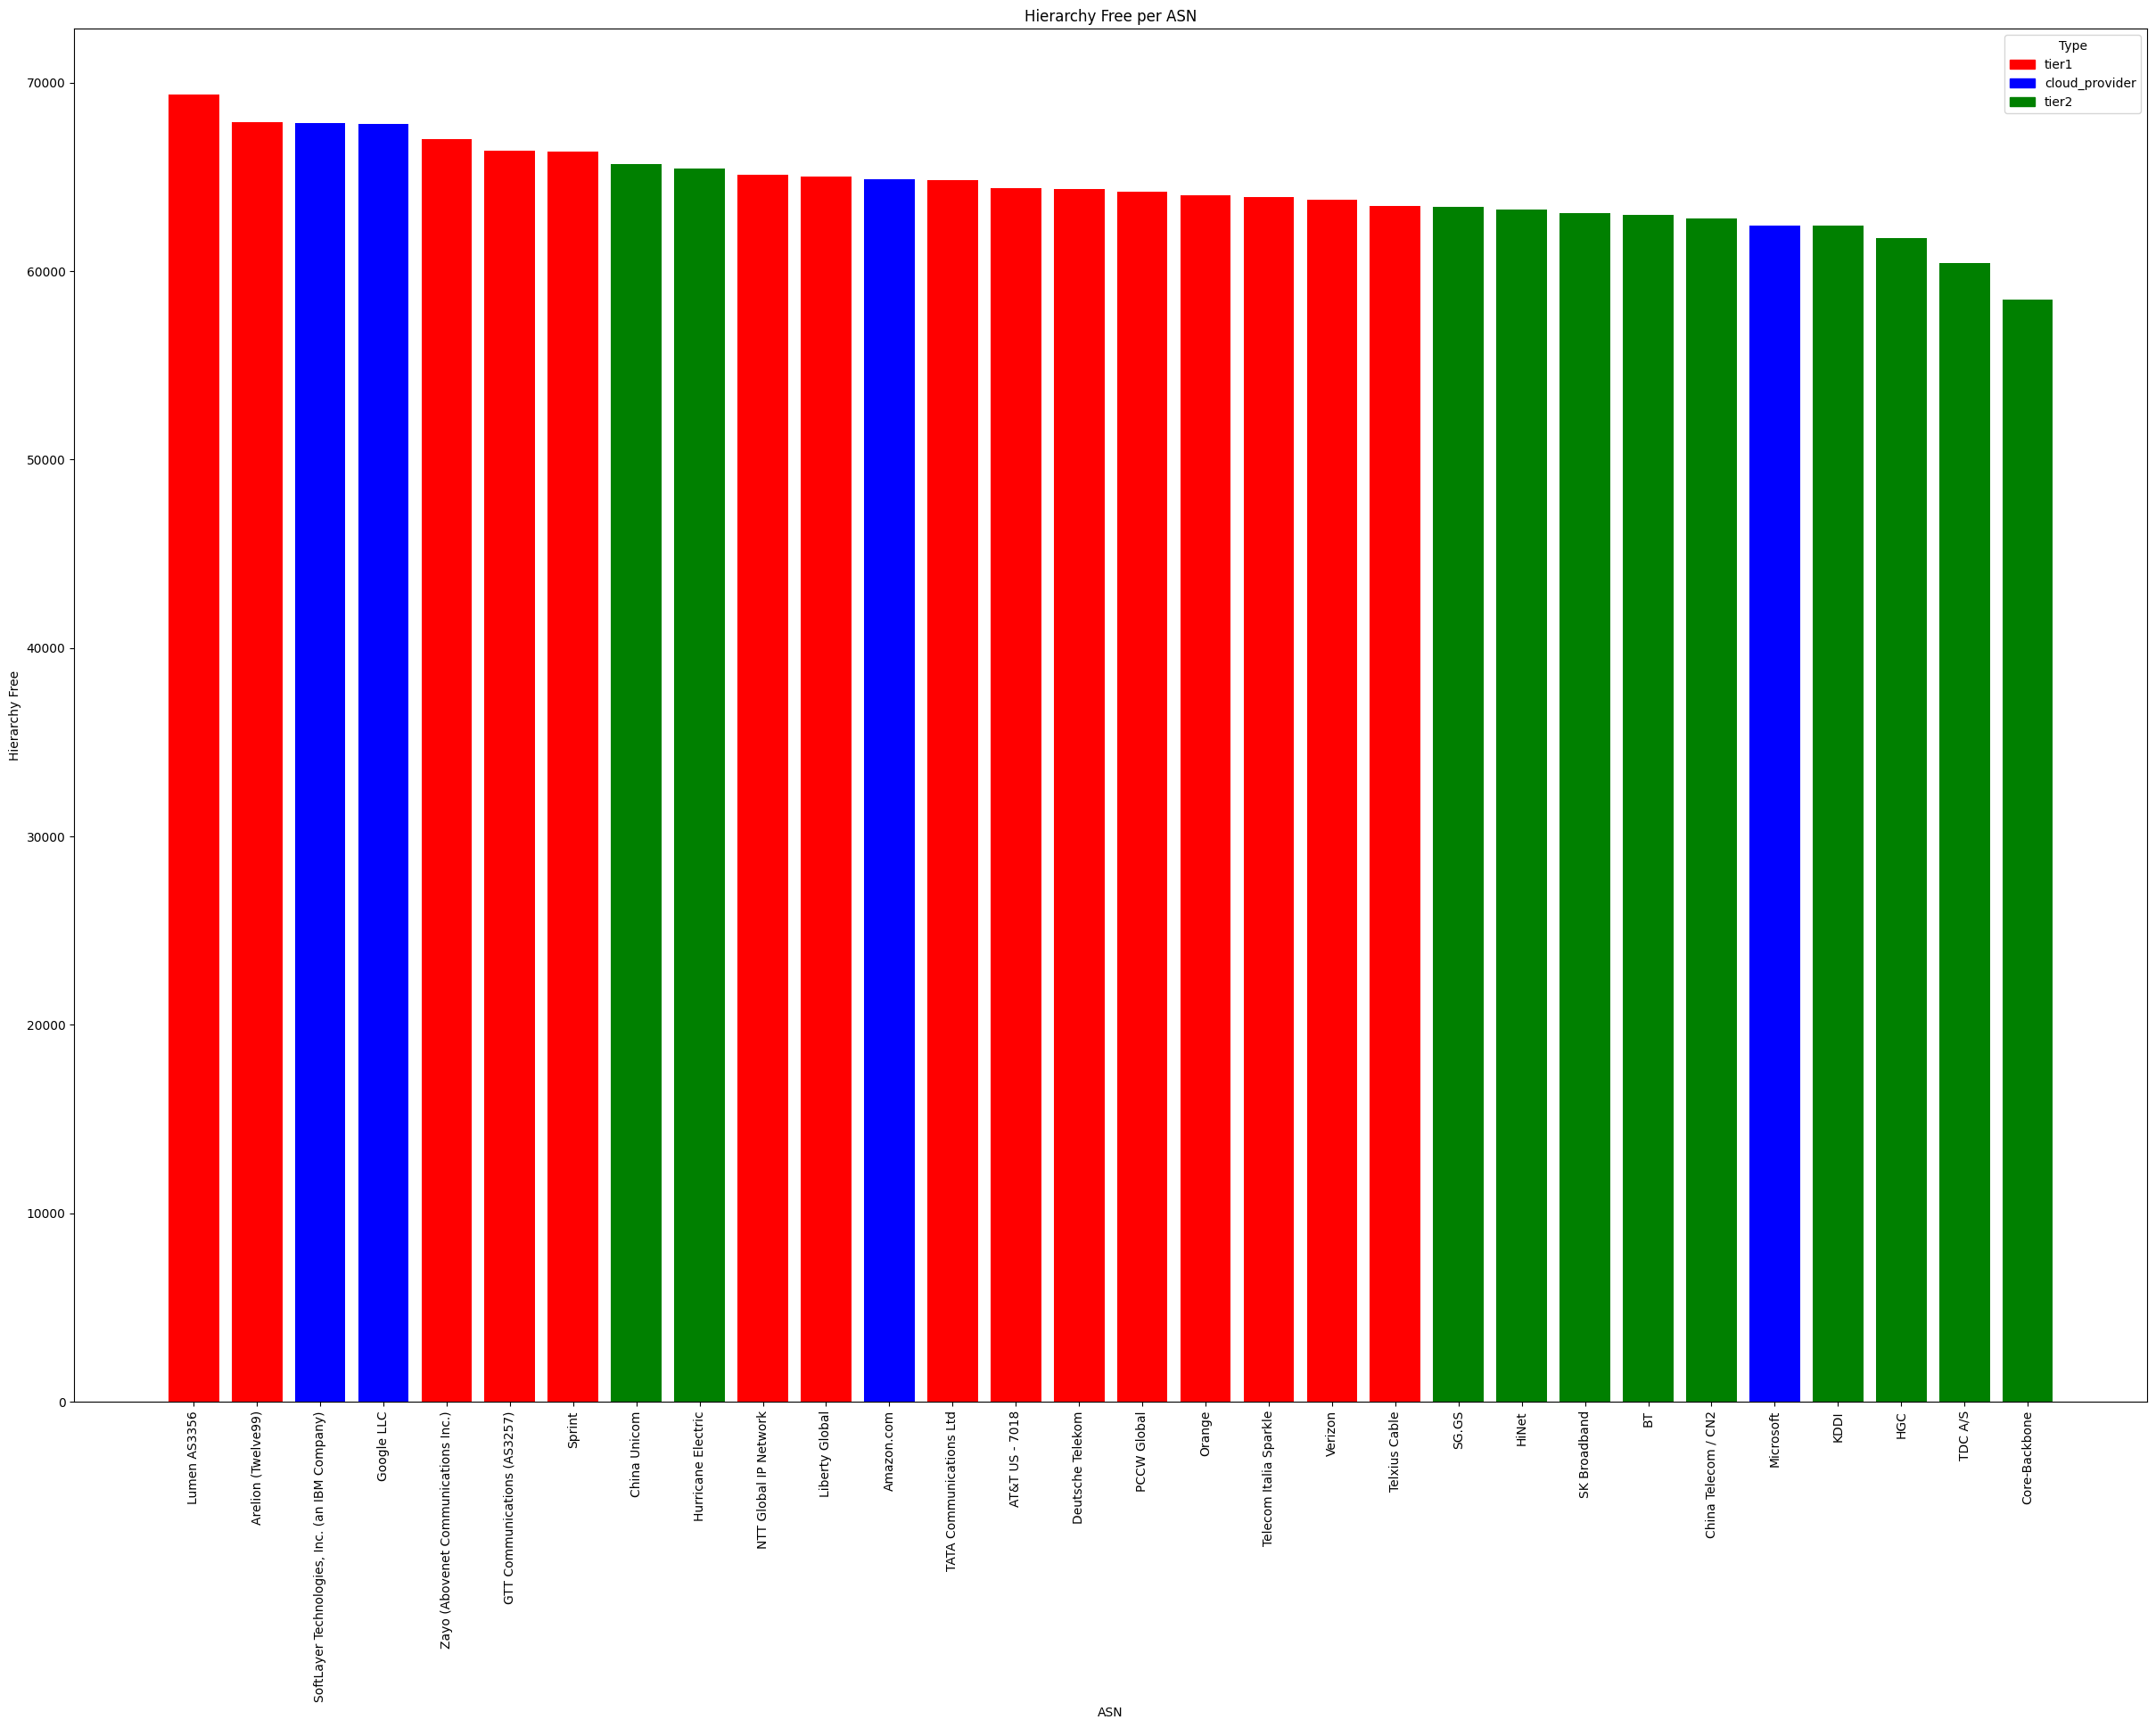

In [5]:
plot_hierarchy_free(df)
df=df[df['type'] != 'other']
plot_hierarchy_free(df)

In [16]:
import subprocess
import csv

def run_whois_command(asn):
    # Define the whois command
    command = ["whois", "-h", "whois.cymru.com", "--", f"-v {asn}"]

    # Run the whois command and capture the output
    try:
        result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, check=True)
        output = result.stdout
        error = result.stderr
        return output, error
    except subprocess.CalledProcessError as e:
        error_message = f"Error executing whois command for ASN {asn}: {e}"
        return None, error_message

# Read ASNs from asn.csv and run whois command for each
with open("asn.csv", "r") as asn_file, open("output.csv", "w", newline='') as output_file:
    csv_writer = csv.writer(output_file)
    csv_writer.writerow(["ASN", "Output"])

    for line in asn_file:
        asn = line.strip()
        output_data, error_message = run_whois_command(asn)

        if output_data is not None:
            #print(f"Output for ASN {asn}:")
            #print(output_data)

            # Write to CSV file
            csv_writer.writerow([output_data])
        else:
            print(f"Error for ASN {asn}:")
            print(error_message)

print("Results saved to output.csv")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

df = pd.read_csv('output.csv')

asn_counts = df['CC'].value_counts()

fig, ax = plt.subplots(figsize=(10, 8))
m = Basemap(projection='mill', llcrnrlat=-60, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawcountries()

for country, count in asn_counts.items():
    lat, lon = m(0, 0)  # Use the center of the map for simplicity
    m.plot(lon, lat, 'bo', markersize=count, label=f'{country}: {count} ASNs')

plt.title('ASN Distribution by Country')
plt.legend()
plt.show()
